# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [10]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [11]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

585

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [12]:
responses = []
url = 'https://api.openweathermap.org/data/2.5/weather'
for city in cities:
    print(f'Hitting OpenWeather API for {city.title()}')
    params = {
        'q': city,
        'appid': weather_api_key
    }

    responses.append(requests.get(url, params))

Hitting OpenWeather API for Atuona
Hitting OpenWeather API for Arlit
Hitting OpenWeather API for Clyde River
Hitting OpenWeather API for Kapaa
Hitting OpenWeather API for Lompoc
Hitting OpenWeather API for Salzwedel
Hitting OpenWeather API for Lincoln
Hitting OpenWeather API for Kudahuvadhoo
Hitting OpenWeather API for Commerce
Hitting OpenWeather API for Yellowknife
Hitting OpenWeather API for Dingle
Hitting OpenWeather API for Mataura
Hitting OpenWeather API for Te Anau
Hitting OpenWeather API for Avarua
Hitting OpenWeather API for Eyl
Hitting OpenWeather API for Provideniya
Hitting OpenWeather API for Puerto Ayora
Hitting OpenWeather API for Upernavik
Hitting OpenWeather API for Port Alfred
Hitting OpenWeather API for Banda Aceh
Hitting OpenWeather API for Airai
Hitting OpenWeather API for Gat
Hitting OpenWeather API for Inta
Hitting OpenWeather API for Hobart
Hitting OpenWeather API for Mayaguez
Hitting OpenWeather API for Albany
Hitting OpenWeather API for Itarema
Hitting OpenWeat

Hitting OpenWeather API for Tank
Hitting OpenWeather API for Ramshir
Hitting OpenWeather API for Paucartambo
Hitting OpenWeather API for San Cristobal
Hitting OpenWeather API for Javanrud
Hitting OpenWeather API for Lesnyye Polyany
Hitting OpenWeather API for Porto-Vecchio
Hitting OpenWeather API for Longyearbyen
Hitting OpenWeather API for Cabo San Lucas
Hitting OpenWeather API for Tabiauea
Hitting OpenWeather API for Torbay
Hitting OpenWeather API for Karaul
Hitting OpenWeather API for Krasnoborsk
Hitting OpenWeather API for La Romana
Hitting OpenWeather API for Tuatapere
Hitting OpenWeather API for Dryden
Hitting OpenWeather API for La Rioja
Hitting OpenWeather API for Livingstonia
Hitting OpenWeather API for Richards Bay
Hitting OpenWeather API for Limon
Hitting OpenWeather API for Alta Floresta
Hitting OpenWeather API for Bonthe
Hitting OpenWeather API for Pisco
Hitting OpenWeather API for Yamada
Hitting OpenWeather API for Tarut
Hitting OpenWeather API for Varhaug
Hitting OpenWea

Hitting OpenWeather API for Nome
Hitting OpenWeather API for Warrnambool
Hitting OpenWeather API for Kuusamo
Hitting OpenWeather API for New Guinlo
Hitting OpenWeather API for Hun
Hitting OpenWeather API for Loukhi
Hitting OpenWeather API for Bacuit
Hitting OpenWeather API for Nichinan
Hitting OpenWeather API for The Valley
Hitting OpenWeather API for Old Bridge
Hitting OpenWeather API for Mutsamudu
Hitting OpenWeather API for Sioux Lookout
Hitting OpenWeather API for Barcelos
Hitting OpenWeather API for Yerbogachen
Hitting OpenWeather API for Auki
Hitting OpenWeather API for Chama
Hitting OpenWeather API for Cayenne
Hitting OpenWeather API for Alyangula
Hitting OpenWeather API for Todos Santos
Hitting OpenWeather API for Pechora
Hitting OpenWeather API for Ijaki
Hitting OpenWeather API for Puerto Ayacucho
Hitting OpenWeather API for Alunitdag
Hitting OpenWeather API for Antalaha
Hitting OpenWeather API for Aklavik
Hitting OpenWeather API for Sirajganj
Hitting OpenWeather API for Cap M

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [13]:
cleaned_responses = []
for response in responses:
    if response.status_code == 200:
        cleaned_responses.append(response)
        
len(cleaned_responses), len(responses)

(529, 585)

In [14]:
df_rows = []
for response in responses:
    data = response.json()
    try:
        weather_col = data['weather']
        df = pd.json_normalize(weather_col)
        df1 = pd.json_normalize(data).drop('weather',axis=1)
        df = pd.concat([df, df1], axis=1)
        df = df.loc[:,~df.columns.duplicated()] # removes second id col
        df_rows.append(df)
    except KeyError:
        df = pd.json_normalize(data)
        df = df.loc[:,~df.columns.duplicated()]
        df_rows.append(df)

In [15]:
num_cols = []
for row in df_rows:
    num_cols.append(len(row.columns))
    
max_cols = max(num_cols)

for col in range(len(num_cols)):
    og_col_num = len(df_rows[col].columns)
    if og_col_num != max_cols:
        col_diff = max_cols - og_col_num
        for new_col in range(col_diff):
            df_rows[col][f'filler_{new_col}'] = np.nan

In [40]:
raw_df = pd.concat(df_rows)
raw_df.index = range(len(raw_df))

In [41]:
raw_df['main.temp_max'] = (raw_df['main.temp_max'] - 273.15) * 9/5 + 32

raw_df = raw_df[['name', 'coord.lat', 'coord.lon', 'main.temp_max', 'main.humidity', 
                'clouds.all', 'wind.speed', 'sys.country', 'dt']]

raw_df = raw_df.rename(columns={
    'name': 'City Name', 
    'coord.lat': 'City Latitude', 
    'coord.lon': 'City Longitude', 
    'main.temp_max': 'Max Tempurature', 
    'main.humidity': 'Humidity',
    'clouds.all': 'Cloud coverage', 
    'wind.speed': 'Wind speed', 
    'sys.country': 'City Country', 
    'dt': 'City datetime'
    })

raw_df = raw_df.dropna()

In [42]:
raw_df.to_csv('../output_data/WeatherPy_output/raw_weather.csv')
raw_df.head()

,City Name,City Latitude,City Longitude,Max Tempurature,Humidity,Cloud coverage,Wind speed,City Country,City datetime
0,Atuona,-9.80,-139.03,77.558,78.0,100.0,8.44,PF,1.609779e+09
1,Arlit,18.74,7.39,84.938,14.0,2.0,2.76,NE,1.609779e+09
2,Clyde River,70.47,-68.59,-18.400,82.0,75.0,7.20,CA,1.609779e+09
3,Kapaa,22.08,-159.32,73.400,78.0,20.0,4.10,US,1.609779e+09
4,Lompoc,34.64,-120.46,46.400,100.0,90.0,2.60,US,1.609779e+09


In [43]:
len(raw_df)

529

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [39]:
# Removing cities with humidity over 100%
# raw_df = raw_df[raw_df['Humidity'] > 100]
# len(raw_df)

0

In [171]:
#  Get the indices of cities that have humidity over 100%.


In [172]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

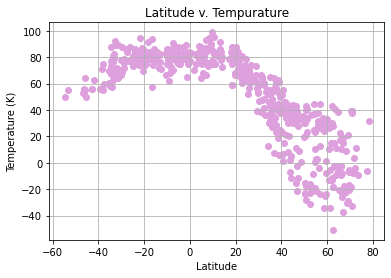

In [44]:
lat = raw_df['City Latitude']
temps = raw_df['Max Tempurature']

plt.scatter(lat, temps, color='plum')
plt.title('Latitude v. Tempurature')
plt.xlabel('Latitude')
plt.ylabel('Temperature (K)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/temps_lat.png', dpi=400)
plt.show()

## Latitude vs. Humidity Plot

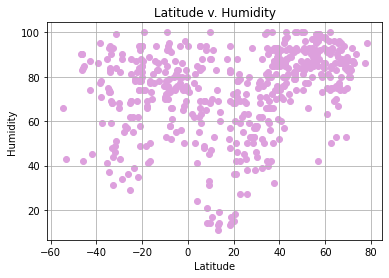

In [45]:
humidity = raw_df['Humidity']

plt.scatter(lat, humidity, color='plum')
plt.title('Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/humidity_lat.png', dpi=400)
plt.show()

## Latitude vs. Cloudiness Plot

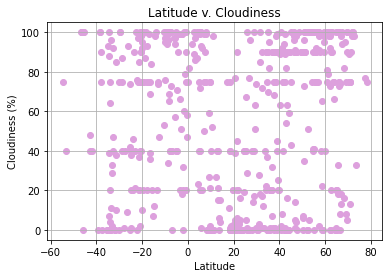

In [46]:
clouds = raw_df['Cloud coverage']

plt.scatter(lat, clouds, color='plum')
plt.title('Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/cloud_lat.png', dpi=400)
plt.show()

## Latitude vs. Wind Speed Plot

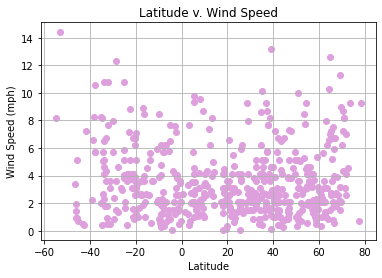

In [47]:
wind_speed = raw_df['Wind speed']

plt.scatter(lat, wind_speed, color='plum')
plt.title('Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/wind_lat.png', dpi=400)
plt.show()

## Linear Regression

In [65]:
n_hem_df = raw_df[raw_df['City Latitude'] > 0]
s_hem_df = raw_df[raw_df['City Latitude'] < 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

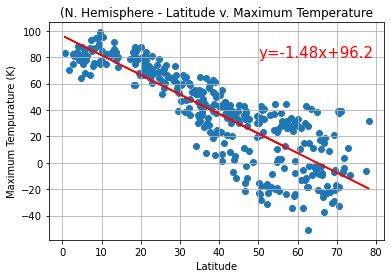

In [68]:
n_lat_max_temp = n_hem_df[['City Latitude','Max Tempurature']]

lat = n_lat_max_temp['City Latitude']
max_temp = n_lat_max_temp['Max Tempurature']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))

plt.scatter(lat, max_temp)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Maximum Temperature')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (50, 80), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_max_temp_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

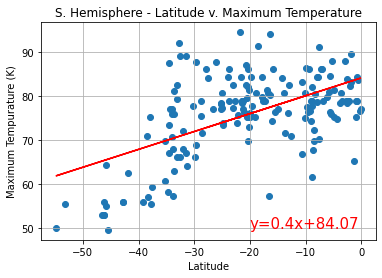

In [69]:
s_lat_max_temp = s_hem_df[['City Latitude','Max Tempurature']]

lat = s_lat_max_temp['City Latitude']
max_temp = s_lat_max_temp['Max Tempurature']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))

plt.scatter(lat, max_temp)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Maximum Temperature')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (-20, 50), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_max_temp_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

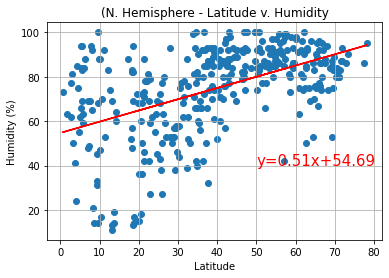

In [70]:
n_lat_humidity = n_hem_df[['City Latitude','Humidity']]

lat = n_lat_humidity['City Latitude']
humidity = n_lat_humidity['Humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, humidity)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (50, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_humidity_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

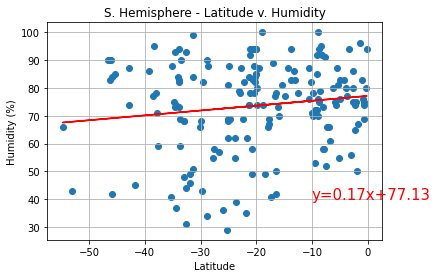

In [71]:
s_lat_humidity = s_hem_df[['City Latitude','Humidity']]

lat = s_lat_humidity['City Latitude']
humidity = s_lat_humidity['Humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, humidity)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (-10, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_humidity_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

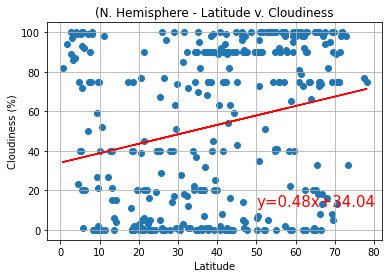

In [72]:
n_lat_cloudiness = n_hem_df[['City Latitude','Cloud coverage']]

lat = n_lat_cloudiness['City Latitude']
cloudiness = n_lat_cloudiness['Cloud coverage']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, cloudiness)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (50, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_cloud_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

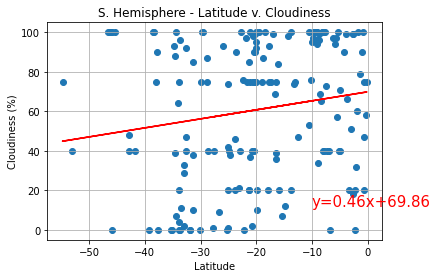

In [73]:
s_lat_cloudiness = s_hem_df[['City Latitude','Cloud coverage']]

lat = s_lat_cloudiness['City Latitude']
cloudiness = s_lat_cloudiness['Cloud coverage']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, cloudiness)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_cloud_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

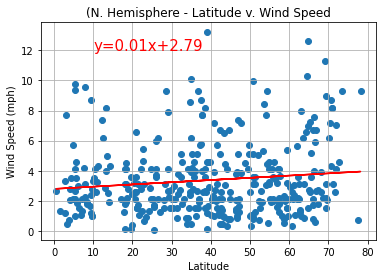

In [63]:
n_lat_wind_speed = n_hem_df[['City Latitude','Wind speed']]

lat = n_lat_wind_speed['City Latitude']
wind_speed = n_lat_wind_speed['Wind speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, wind_speed)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('(N. Hemisphere - Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_wind_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

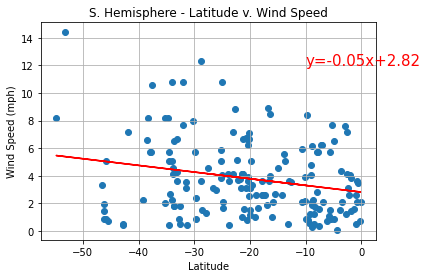

In [74]:
s_lat_wind_speed = s_hem_df[['City Latitude','Wind speed']]

lat = s_lat_wind_speed['City Latitude']
wind_speed = s_lat_wind_speed['Wind speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(lat, wind_speed)
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('S. Hemisphere - Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_wind_lat.png', dpi=400)
plt.show()